<a href="https://colab.research.google.com/github/cristianmunoz1/DeepLearning-Project/blob/main/03_baseline_architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Arquitectura de linea base
Esta primera versión del modelo permite comprobar que todo el flujo de trabajo desde la carga de datos, preprocesamiento, entrenamiento, evaluación y almacenamiento de resultados funciona de forma coherente y sin errores. En este caso no tenemos la expectativa de obtener un desempeño muy alto, sino establecer un punto de partida estable y reproducible. A partir de esta referencia inicial se podrán introducir ajustes, comparar mejoras e incorporar arquitecturas más complejas con mayor confianza, inclinandose con mayor fuerza en Transfer Learning.

### Carga de datos
Se hace uso del mismo proceso para la adquisición de datos desde la API de Kaggle y el preprocesado ya definido


In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
import os

files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jhonatangranda","key":"0f547dc8ab8b2e9acb4f8c16c675367c"}'}

In [ ]:
 !mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d nikitarom/planets-dataset
!unzip -q planets-dataset.zip -d data/

Dataset URL: https://www.kaggle.com/datasets/nikitarom/planets-dataset
License(s): DbCL-1.0
 99% 1.48G/1.50G [00:18<00:00, 160MB/s]
100% 1.50G/1.50G [00:18<00:00, 88.5MB/s]


In [ ]:
import os
print(os.listdir("data"))
print("------------")
print(os.listdir("data/planet/planet"))

['planet', 'test-jpg-additional']
------------
['train-jpg', 'sample_submission.csv', 'train_classes.csv', 'test-jpg']


 ## Importar librerias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Definición de rutas base

En esta etapa se establecen las ubicaciones principales donde residen los datos necesarios para el proceso. En particular, se utiliza `TRAIN_JPG_DIR` como ruta principal en este notebook para acceder a todas las imágenes etiquetadas disponibles. A partir de ese directorio se realiza la partición del dataset, separando muestras para entrenamiento y validación. Aunque las imágenes del conjunto de validación no participan durante el aprendizaje, sí cuentan con etiquetas conocidas, lo que permite evaluar el desempeño del modelo sobre ejemplos nuevos y medir su capacidad de generalización desde el inicio del flujo.

In [ ]:
PROJECT_FOLDER = 'data/planet/planet'
TRAIN_JPG_DIR = os.path.join(PROJECT_FOLDER, 'train-jpg')
TRAIN_CSV_PATH = os.path.join(PROJECT_FOLDER, 'train_classes.csv')

# Hiperparámetros
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 0.001

#Configuración
print(f"Tamaño de imagen: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Épocas: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")


Tamaño de imagen: (128, 128)
Batch size: 32
Épocas: 5
Learning rate: 0.001


In [ ]:
# Cargar CSV
train_df = pd.read_csv(TRAIN_CSV_PATH)

# Convertir etiquetas a formato binario
dummies = train_df['tags'].str.get_dummies(' ')
labels = dummies.columns.values
N_LABELS = len(labels)
train_df = pd.concat([train_df, dummies], axis=1)

# Dividir en train y validation
train_data, val_data = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

print(f"Train: {len(train_data)} imágenes")
print(f"Validation: {len(val_data)} imágenes")
print(f"Número de clases: {N_LABELS}")


Train: 32383 imágenes
Validation: 8096 imágenes
Número de clases: 17


## Definición de funciones de preprocesado
En este apartado se declaran las funciones encargadas de transformar las imágenes antes de ingresarlas al modelo. Aunque en el notebook anterior se detalla mas a fondo el proceso completo, aquí se utiliza en funciones simplificadas cuyo objetivo principal es estandarizar el input: cargar cada imagen, ajustar su tamaño a la resolución definida y normalizar sus valores de píxeles. Con esto se garantiza que todas las muestras mantengan el mismo formato y rango numérico, permitiendo que el modelo reciba datos consistentes durante el entrenamiento y la validación.

In [ ]:
def load_and_preprocess_image(img_name, img_size=IMG_SIZE):
    """
    Carga una imagen, la redimensiona y normaliza.
    """
    img_path = os.path.join(TRAIN_JPG_DIR, f"{img_name}.jpg")
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalizar a [0, 1]
    return img_array


def data_generator(dataframe, batch_size=32, img_size=IMG_SIZE, shuffle=True):
    """
    Generador que carga imágenes en lotes.
    """
    n_samples = len(dataframe)
    indices = np.arange(n_samples)

    while True:
        if shuffle:
            np.random.shuffle(indices)

        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            batch_indices = indices[start:end]

            batch_images = []
            batch_labels = []

            for idx in batch_indices:
                row = dataframe.iloc[idx]
                img = load_and_preprocess_image(row['image_name'], img_size)
                label = row[labels].values.astype('float32')

                batch_images.append(img)
                batch_labels.append(label)

            yield np.array(batch_images), np.array(batch_labels)

Se definen los generadores y el tamaño para las epocas de entrenamiento de la red neuronal

In [ ]:
steps_per_epoch_train = len(train_data) // BATCH_SIZE
steps_per_epoch_val = len(val_data) // BATCH_SIZE

train_generator = data_generator(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_generator = data_generator(val_data, batch_size=BATCH_SIZE, shuffle=False)

print(f" Steps por época (train): {steps_per_epoch_train}")
print(f" Steps por época (val): {steps_per_epoch_val}")


 Steps por época (train): 1011
 Steps por época (val): 253


## Construcción de la Arquitectura
Para esta línea base se implementa una red neuronal convolucional sencilla, diseñada para capturar patrones visuales fundamentales presentes en las imágenes satelitales. La arquitectura está compuesta por tres bloques convolucionales consecutivos, donde cada uno utiliza filtros cada vez más numerosos `(32, 64 y 128)`, permitiendo que la red aprenda desde bordes y texturas simples hasta estructuras más complejas. Cada bloque incluye una capa `MaxPooling`, encargada de reducir progresivamente la resolución espacial, disminuyendo el costo computacional y reteniendo las características más relevantes.

Una vez extraídas las representaciones espaciales, la salida se aplana mediante `Flatten` para conectar con la parte densa del modelo, donde una capa totalmente conectada de 256 neuronas con activación `ReLU` actúa como clasificador intermedio. Se incorpora `Dropout` del 0.5 para mitigar el sobreajuste, desactivando aleatoriamente neuronas durante el entrenamiento. Finalmente, la capa de salida utiliza activación `sigmoid`, adecuada para clasificación multietiqueta, ya que permite asignar múltiples clases de manera independiente a una misma imagen.

In [ ]:
def build_simple_cnn(input_shape=(128, 128, 3), num_classes=17):
    """
    Arquitectura:
    - 3 bloques convolucionales (Conv + MaxPool)
    - Flatten
    - 2 capas densas
    - Salida con sigmoid
    """
    model = Sequential([
        # Bloque 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        # Bloque 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Bloque 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Clasificador
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])

    return model


model = build_simple_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=N_LABELS)
#Arquitectura
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 17)             │         4,369 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,486,481 (32.37 MB)

 Trainable params: 8,486,481 (32.37 MB)

 Non-trainable params: 0 (0.00 B)

###Proceso de compilación
A continuación realizamos el `compile` para ver los elementos que estaran presentes en el proceso de calibración. Se utiliza el optimizador Adam, adecuado para ajustarse dinámicamente a los gradientes y facilitar una convergencia estable. La función de pérdida seleccionada es binary_crossentropy, apropiada para problemas de clasificación multietiqueta, ya que evalúa cada clase de forma independiente. Además, se incorporan métricas complementarias como accuracy, precision y recall, que permiten analizar el desempeño desde distintas perspectivas. Finalmente, se agrega el F2-score como métrica principal, debido a que otorga mayor peso al recall, lo cual es especialmente útil cuando interesa reducir falsos negativos y asegurar que el modelo identifique la mayor cantidad posible de etiquetas presentes en una imagen.

In [ ]:

from tensorflow.keras.metrics import FBetaScore
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             FBetaScore(beta=2.0, threshold=0.5, name='f2_score')]
)

print(" Optimizer: Adam")
print(" Loss: binary_crossentropy")
print(" Metrics: accuracy, precision, recall, f2_score")

##F2 promeidado, sin array
            ## FBetaScore(beta=2.0, threshold=0.5, average='micro', name='f2_score')]


 Optimizer: Adam
 Loss: binary_crossentropy
 Metrics: accuracy, precision, recall, f2_score


## Configuración de Callbacks

Se definen callbacks con el fin de supervisar y optimizar el proceso de entrenamiento. El primero es `ModelCheckpoint`, encargado de guardar automáticamente el modelo únicamente cuando obtiene el mejor desempeño en el conjunto de validación, evaluado mediante la menor `val_loss`. Esto evita conservar versiones sobreajustadas y garantiza disponer del modelo más estable. Adicionalmente, se define `EarlyStopping`, pero inicialmente no se usa, el propósito es detener el entrenamiento cuando la pérdida de validación deja de mejorar después de cierto número de épocas, evitando así un sobreentrenamiento innecesario. Al activar `restore_best_weights`, el modelo recupera los parámetros correspondientes al mejor punto del entrenamiento. Ambos mecanismos contribuyen a eficiencia computacional y mejor generalización.

In [ ]:
# Guardar el mejor modelo
checkpoint = ModelCheckpoint(
    'modelo_baseline_best.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

callbacks = [checkpoint]

Proceso de entrenamiento de la red

In [ ]:
#proceso de entrenamiento
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    validation_data=val_generator,
    validation_steps=steps_per_epoch_val,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0300 - f2_score: 0.1825 - loss: 0.2414 - precision: 0.7967 - recall: 0.6138
Epoch 1: val_loss improved from inf to 0.17785, saving model to modelo_baseline_best.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1289s 1s/step - accuracy: 0.0300 - f2_score: 0.1825 - loss: 0.2414 - precision: 0.7967 - recall: 0.6138 - val_accuracy: 0.0277 - val_f2_score: 0.2388 - val_loss: 0.1779 - val_precision: 0.8763 - val_recall: 0.6750
Epoch 2/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0454 - f2_score: 0.2741 - loss: 0.1820 - precision: 0.8559 - recall: 0.6925
Epoch 2: val_loss improved from 0.17785 to 0.16407, saving model to modelo_baseline_best.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1284s 1s/step - accuracy: 0.0454 - f2_score: 0.2741 - loss: 0.1820 - precision: 0.8559 - recall: 0.6925 - val_accuracy: 0.0272 - val_f2_score: 0.2768 - val_loss: 0.1641 - val_precision: 0.8661 - val_recall: 0.7336
Epoch 3/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0788 - f2_score: 0.3147 - loss: 0.1620 - precision: 0.8721 - recall: 0.7308
Epoch 3: val_loss improved from 0.16407 to 0.14623, saving model to modelo_baseline_best.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1281s 1s/step - accuracy: 0.0788 - f2_score: 0.3147 - loss: 0.1620 - precision: 0.8721 - recall: 0.7308 - val_accuracy: 0.0526 - val_f2_score: 0.3252 - val_loss: 0.1462 - val_precision: 0.9021 - val_recall: 0.7361
Epoch 4/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1036 - f2_score: 0.3285 - loss: 0.1499 - precision: 0.8812 - recall: 0.7502
Epoch 4: val_loss improved from 0.14623 to 0.14034, saving model to modelo_baseline_best.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1351s 1s/step - accuracy: 0.1036 - f2_score: 0.3285 - loss: 0.1499 - precision: 0.8812 - recall: 0.7502 - val_accuracy: 0.0639 - val_f2_score: 0.3577 - val_loss: 0.1403 - val_precision: 0.8802 - val_recall: 0.7807
Epoch 5/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1157 - f2_score: 0.3501 - loss: 0.1424 - precision: 0.8840 - recall: 0.7652
Epoch 5: val_loss improved from 0.14034 to 0.13370, saving model to modelo_baseline_best.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1273s 1s/step - accuracy: 0.1157 - f2_score: 0.3501 - loss: 0.1424 - precision: 0.8840 - recall: 0.7652 - val_accuracy: 0.0695 - val_f2_score: 0.3555 - val_loss: 0.1337 - val_precision: 0.8933 - val_recall: 0.7789


## Curvas de aprendizaje


En esta sección se recuperan las métricas registradas durante el entrenamiento `[precisión, recall, accuracy y pérdida]` tanto para el conjunto de entrenamiento como para el de validación. Dado que algunas versiones de Keras no devuelven directamente el F2-Score por época, surge la necesiadad de realizar el cálculo manual a partir de precisión y recall, aplicando la fórmula correspondiente. Esto permite disponer de una métrica adicional alineada con el objetivo del problema, especialmente útil en escenarios donde es más importante detectar correctamente las clases presentes que evitar falsos positivos.


Partiendo de la forma general de la metrica F score, obtenemos que:

$$
F_{2} = \frac{5 \cdot \text{Precision} \cdot \text{Recall}}{4 \cdot \text{Precision} + \text{Recall}}
$$


### Análisis visual del entrenamiento y cálculo del F2-Score
Posteriormente, se generan múltiples gráficos comparativos que muestran cómo evolucionan las métricas a lo largo de las épocas. Esta visualización facilita identificar comportamientos relevantes como mejora progresiva, estancamiento, posibles señales de sobreajuste o diferencias entre entrenamiento y validación. Finalmente, se reporta el F2-Score obtenido en la última época de validación, empleándolo como referencia para evaluar el desempeño global del modelo.

Train F2 por época: [0.66903966 0.73167168 0.75943603 0.7739151  0.78871213]
Val F2 por época: [0.7075113  0.75672179 0.76424698 0.79873997 0.79939002]


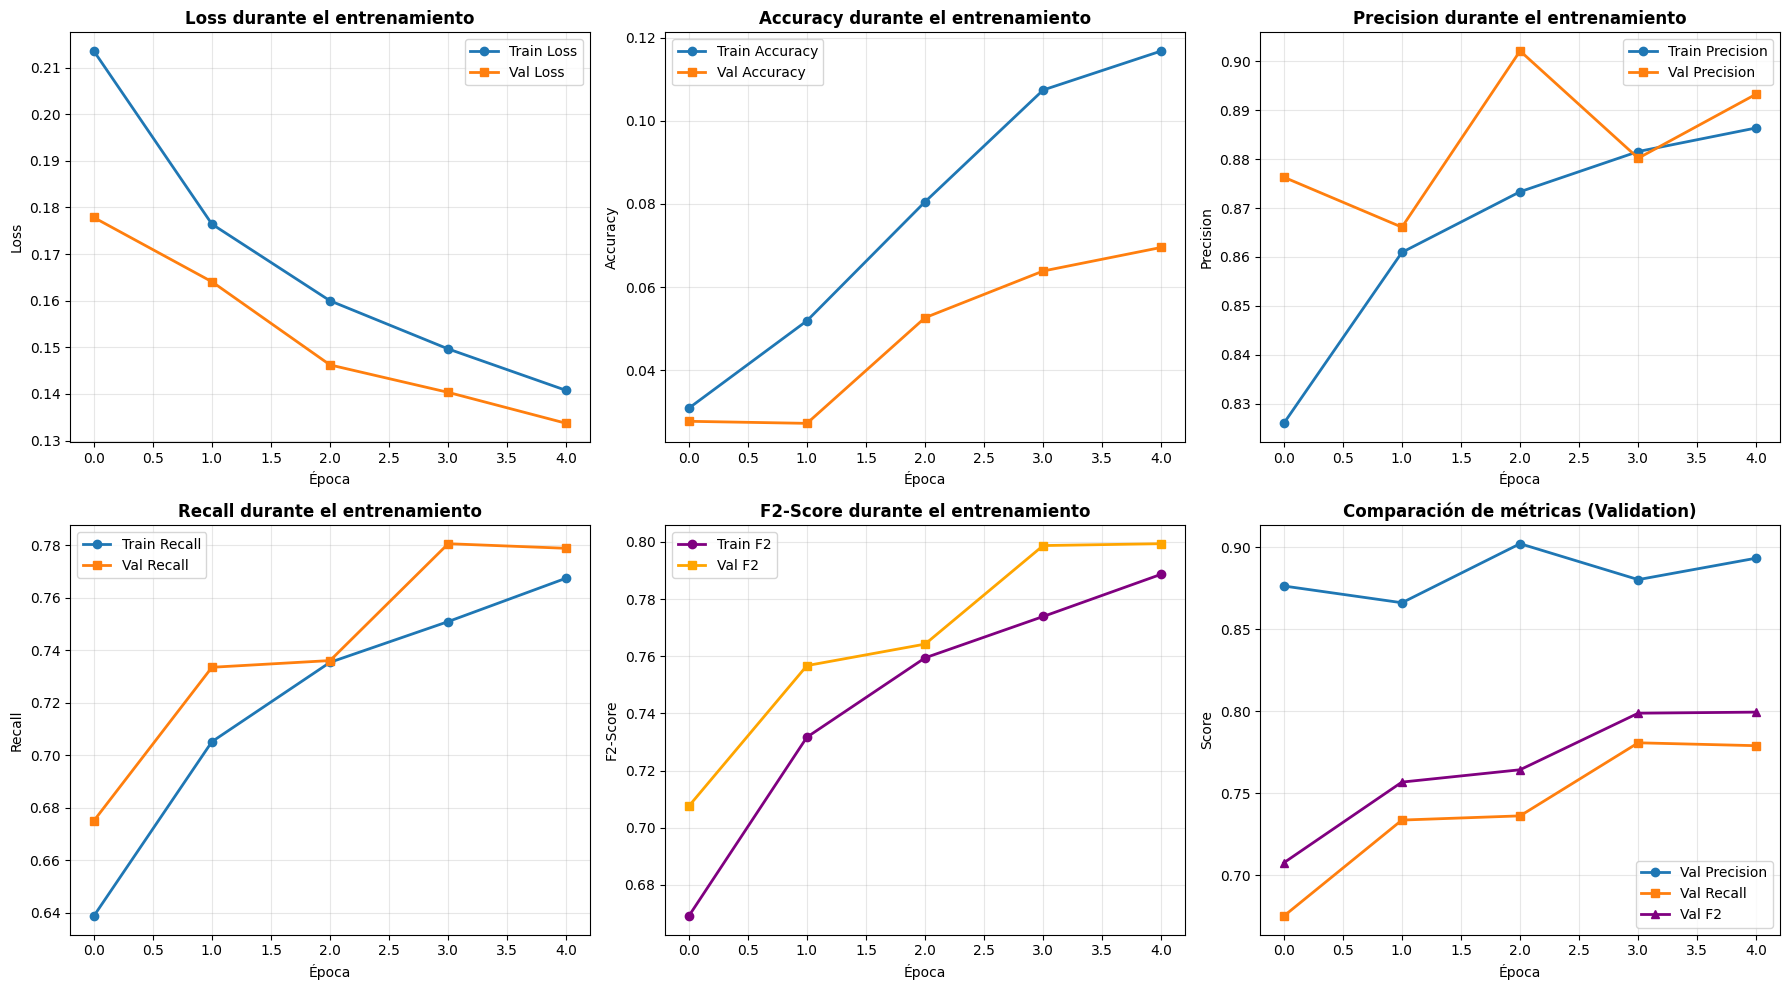

F2-Score final (validation): 0.7994


In [ ]:

import numpy as np

# Extraer precision y recall del history
train_precision = np.array(history.history['precision'])
train_recall = np.array(history.history['recall'])
val_precision = np.array(history.history['val_precision'])
val_recall = np.array(history.history['val_recall'])

# Calcular F2 manualmente
def calculate_f2(precision, recall):
    """Calcula F2-Score desde precision y recall, solucionar problema de array de valores"""
    return (5 * precision * recall) / (4 * precision + recall)

train_f2 = calculate_f2(train_precision, train_recall)
val_f2 = calculate_f2(val_precision, val_recall)

#Calculo del F2 promedio -- Calculo micro
print(f"Train F2 por época: {train_f2}")
print(f"Val F2 por época: {val_f2}")


fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss', marker='o', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', marker='s', linewidth=2)
axes[0, 0].set_title('Loss durante el entrenamiento', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Época')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy', marker='o', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy', marker='s', linewidth=2)
axes[0, 1].set_title('Accuracy durante el entrenamiento', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Época')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision
axes[0, 2].plot(train_precision, label='Train Precision', marker='o', linewidth=2)
axes[0, 2].plot(val_precision, label='Val Precision', marker='s', linewidth=2)
axes[0, 2].set_title('Precision durante el entrenamiento', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Época')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# Recall
axes[1, 0].plot(train_recall, label='Train Recall', marker='o', linewidth=2)
axes[1, 0].plot(val_recall, label='Val Recall', marker='s', linewidth=2)
axes[1, 0].set_title('Recall durante el entrenamiento', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Época')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# F2-Score (calculado manualmente)
axes[1, 1].plot(train_f2, label='Train F2', marker='o', color='purple', linewidth=2)
axes[1, 1].plot(val_f2, label='Val F2', marker='s', color='orange', linewidth=2)
axes[1, 1].set_title('F2-Score durante el entrenamiento', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Época')
axes[1, 1].set_ylabel('F2-Score')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# Comparación de métricas
axes[1, 2].plot(val_precision, label='Val Precision', marker='o', linewidth=2)
axes[1, 2].plot(val_recall, label='Val Recall', marker='s', linewidth=2)
axes[1, 2].plot(val_f2, label='Val F2', marker='^', color='purple', linewidth=2)
axes[1, 2].set_title('Comparación de métricas (Validation)', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Época')
axes[1, 2].set_ylabel('Score')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"F2-Score final (validation): {val_f2[-1]:.4f}")


## Conclusiónes
De manera general podemos ver lo siguiente en el resumen grafico mostrado:

* El loss de entrenamiento disminuye de forma consistente, lo que indica que el modelo está aprendiendo.

* El loss de validación baja ligeramente, pero es más inestable, sugiriendo riesgo leve de sobreajuste.

* Accuracy en validación es baja y variable, por lo que no es una métrica útil en este problema multietiqueta.

* Precision en validación se mantiene alta (~0.89–0.90), mostrando que el modelo evita activar etiquetas incorrectas.

* Recall en validación es más bajo y estable (~0.78–0.79), lo que indica que el modelo aún deja etiquetas sin detectar.

* El F2-score en validación se mantiene estable (~0.80–0.81), lo que refleja un desempeño moderado priorizando recall.

 En conjunto, el modelo base aprende, generaliza razonablemente y tiene buen punto de partida, pero aún puede mejorar especialmente en recall y F2 mediante mejores arquitecturas, que esperamos mejorar con el trasnfer learning.

### Evaluación con validación
En esta etapa se ejecuta el modelo entrenado sobre el conjunto de validación, el cual contiene imágenes nunca vistas durante el entrenamiento pero con etiquetas conocidas. Esto permite obtener una estimación realista del rendimiento del modelo y verificar su capacidad de generalización.

Se consolidan las métricas principales `[loss, accuracy, precision y recall]` directamente desde `model.evaluate()`, y posteriormente se calcula manualmente el F2-score, ya que esta métrica prioriza el recall y resulta más adecuada en tareas multietiqueta como esta, donde es importante capturar todas las clases presentes en una imagen.

In [ ]:
val_gen_eval = data_generator(val_data, batch_size=BATCH_SIZE, shuffle=False)
results = model.evaluate(val_gen_eval, steps=steps_per_epoch_val, verbose=1)

#
print(f" Val Loss: {results[0]:.4f}")
print(f" Val Accuracy: {results[1]:.4f}")
print(f" Val Precision: {results[2]:.4f}")
print(f" Val Recall: {results[3]:.4f}")

# Calcular F2
val_f2_calculated = (5 * results[2] * results[3]) / (4 * results[2] + results[3])
print(f"Val F2-Score : {val_f2_calculated:.4f}")

253/253 ━━━━━━━━━━━━━━━━━━━━ 87s 343ms/step - accuracy: 0.0653 - f2_score: 0.3578 - loss: 0.1329 - precision: 0.8963 - recall: 0.7813
 Val Loss: 0.1334
 Val Accuracy: 0.0697
 Val Precision: 0.8936
 Val Recall: 0.7794
Val F2-Score : 0.7999


## Comportamiento de las predicciones
En esta sección se analiza cualitativamente el desempeño del modelo, visualizando cómo clasifica imágenes del conjunto de validación. Para ello, se selecciona una muestra aleatoria de imágenes que no participaron en el entrenamiento pero cuentan con etiquetas reales, lo que permite comparar directamente la predicción del modelo con la verdad de referencia.

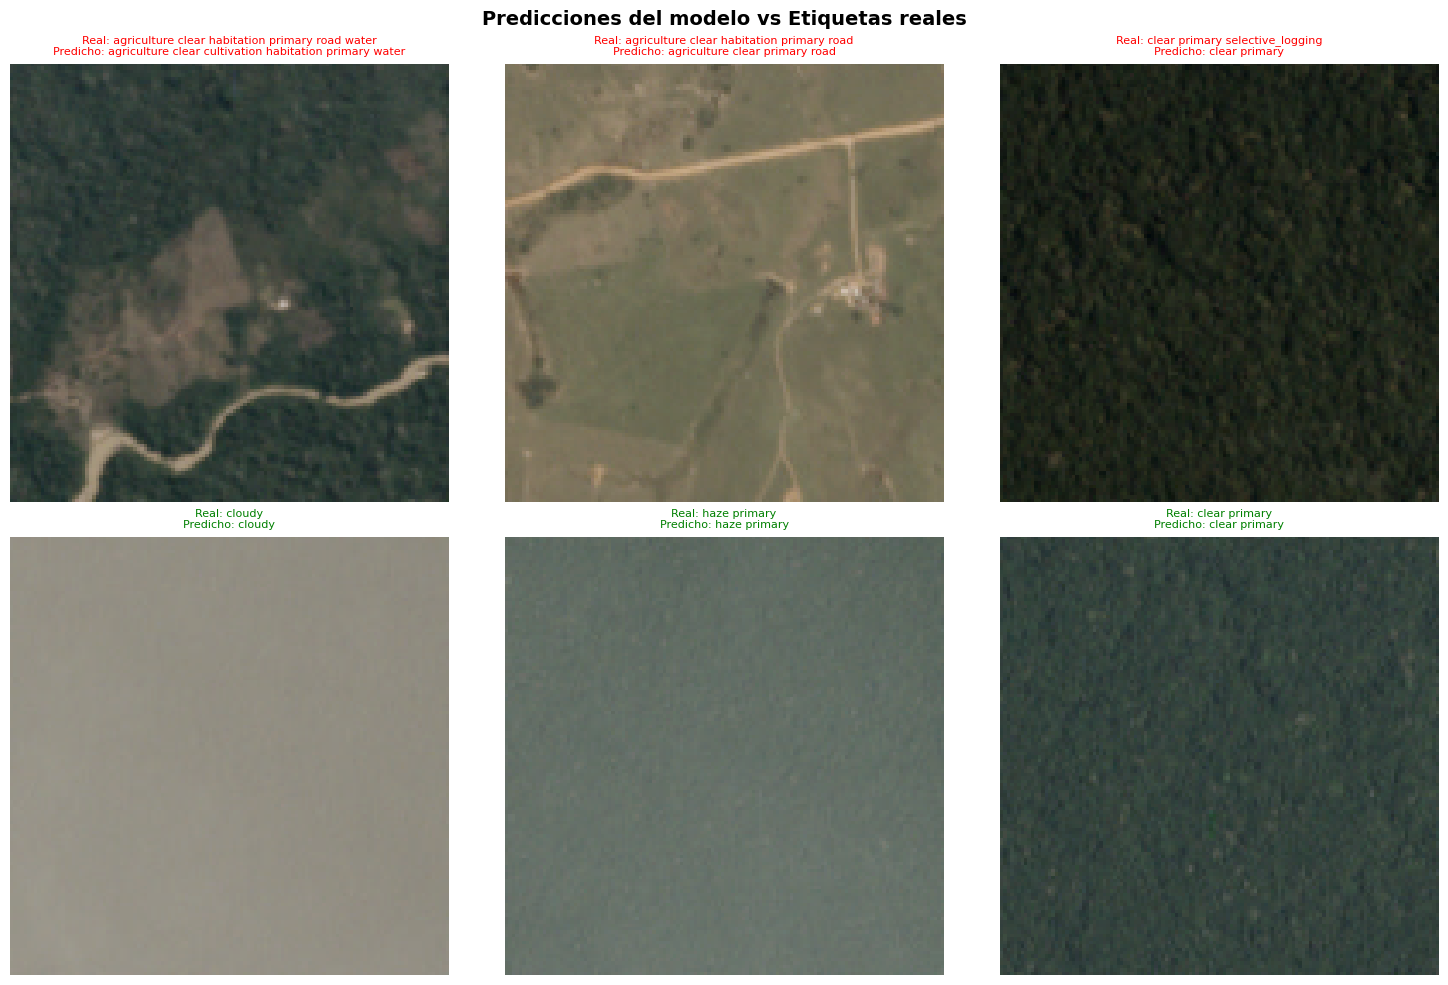

In [ ]:
sample_val = val_data.sample(6, random_state=42)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Predicciones del modelo vs Etiquetas reales', fontsize=14, fontweight='bold')

for i, row in enumerate(sample_val.itertuples()):
    # Cargar imagen
    img = load_and_preprocess_image(row.image_name)
    img_batch = np.expand_dims(img, axis=0)

    # Predecir
    predictions = model.predict(img_batch, verbose=0)[0]

    # Obtener etiquetas predichas (umbral 0.5)
    predicted_labels = [labels[j] for j, pred in enumerate(predictions) if pred > 0.5]

    # Etiquetas reales
    real_labels = row.tags.split()

    # Visualizar
    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')

    title = f"Real: {' '.join(real_labels)}\nPredicho: {' '.join(predicted_labels) if predicted_labels else 'ninguna'}"
    ax.set_title(title, fontsize=8, color='green' if set(predicted_labels) == set(real_labels) else 'red')

plt.tight_layout()
plt.show()


### Rendimiento por clase
Luego de obtener predicciones para todo el conjunto de validación, se realiza un análisis detallado por etiqueta con el objetivo de evaluar cómo se comporta el modelo individualmente en cada clase. Para ello, las probabilidades generadas por el modelo se convierten en salidas binarias mediante un umbral de decisión de 0.5, indicando si una clase está presente o no en cada imagen.

Este desglose permite identificar clases que el modelo predice con alta confianza, clases con baja detectabilidad y posibles desequilibrios del dataset. En general, se espera que las clases más frecuentes en el entrenamiento tengan mejores métricas, mientras que las menos representadas pueden presentar menor recall o F2. Esta información es clave para futuras mejoras, como ajuste de umbrales por clase, data augmentation específico o técnicas para manejar desbalanceo

In [ ]:
# Hacer predicciones en todo el conjunto de validación

all_predictions = []
all_true_labels = []

val_gen_predict = data_generator(val_data, batch_size=BATCH_SIZE, shuffle=False)

for i in range(steps_per_epoch_val):
    X_batch, y_batch = next(val_gen_predict)
    preds = model.predict(X_batch, verbose=0)
    all_predictions.extend(preds)
    all_true_labels.extend(y_batch)

all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Aplicar umbral
predicted_binary = (all_predictions > 0.5).astype(int)

# Calcular métricas por clase
from sklearn.metrics import precision_score, recall_score, fbeta_score

class_metrics = []
for i, label in enumerate(labels):
    precision = precision_score(all_true_labels[:, i], predicted_binary[:, i], zero_division=0)
    recall = recall_score(all_true_labels[:, i], predicted_binary[:, i], zero_division=0)
    f2 = fbeta_score(all_true_labels[:, i], predicted_binary[:, i], beta=2, zero_division=0)
    support = all_true_labels[:, i].sum()

    class_metrics.append({
        'Clase': label,
        'Precision': precision,
        'Recall': recall,
        'F2-Score': f2,
        'Support': int(support)
    })

metrics_df = pd.DataFrame(class_metrics)
metrics_df = metrics_df.sort_values('F2-Score', ascending=False)

print(metrics_df.to_string(index=False))

            Clase  Precision   Recall  F2-Score  Support
          primary   0.973952 0.981218  0.979756     7507
            clear   0.960267 0.953561  0.954895     5728
    partly_cloudy   0.895577 0.857639  0.864967     1440
           cloudy   0.752834 0.840506  0.821376      395
      agriculture   0.805738 0.701762  0.720353     2441
             road   0.772612 0.582908  0.613011     1568
             haze   0.746631 0.519700  0.553336      533
   artisinal_mine   0.714286 0.357143  0.396825       70
       habitation   0.690027 0.344549  0.382890      743
            water   0.693166 0.340644  0.379216     1459
      cultivation   0.515337 0.194444  0.222105      864
      bare_ground   0.611111 0.062857  0.076602      175
         blooming   0.000000 0.000000  0.000000       64
conventional_mine   0.000000 0.000000  0.000000       22
        blow_down   0.000000 0.000000  0.000000       25
selective_logging   0.000000 0.000000  0.000000       61
       slash_burn   0.000000 0.

En este caso vemos que con la arquitectura base que planteamos, hubo clases raras que no es capaz de predecir, de 17 clases, solo tiene capacidad de generalización para 12 de estas.

El rendimiento del modelo muestra un comportamiento marcadamente desigual entre las diferentes clases. En las clases más frecuentes y visualmente consistentes, como `[primary, clear, partly_cloudy, cloudy]`, el modelo alcanza valores altos de precisión, recall y F2-score, lo que indica que la arquitectura base es capaz de aprender los patrones más dominantes del dataset. Sin embargo, a medida que las clases se vuelven menos comunes o más complejas, el desempeño comienza a disminuir. En categorías de frecuencia media, como `[agriculture, road, haze, water]` y otras similares, el modelo logra reconocer algunos ejemplos, pero con un recall sustancialmente menor. Esto revela que, aunque aprende ciertos rasgos de estas clases, su capacidad de generalización sigue siendo limitada, probablemente debido a la falta de representatividad o a la complejidad visual de estas categorías.

La limitación más evidente aparece en las clases raras, como `[blooming, conventional_mine, blow_down, selective_logging , slash_burn]`, donde la precisión, recall y F2-score son completamente nulos. Esto significa que el modelo no predice ni un solo ejemplo perteneciente a estas clases. Esta falla es típica en modelos baseline sin mecanismos de compensación: la combinación de muy pocos ejemplos, baja variabilidad y desbalance extremo hace que estas categorías no aporten suficiente señal durante el entrenamiento, por lo que el modelo aprende a ignorarlas por completo y se centra en las clases dominantes.

En conjunto, estos resultados muestran que, de las 17 clases del problema, la arquitectura base solo logra generalizar razonablemente en unas 12, mientras que las otras 5 quedan totalmente fuera de su capacidad predictiva. Esta configuración deja claro que el modelo baseline es insuficiente para capturar la complejidad total del dataset, especialmente en las clases minoritarias. Mejorar este desempeño requerirá técnicas adicionales como rebalanceo, ajuste de umbrales, pérdidas focalizadas, aumento de datos o la adopción de modelos más potentes, que posteriormente se buscará abordar mediante transfer learning.

